In [1]:
import investpy as ip
from datetime import datetime
import numpy as np
from tqdm import tqdm
import pandas as pd
from finquant.portfolio import build_portfolio
import warnings
warnings.filterwarnings('ignore')

In [2]:
today = datetime.today().date().strftime('%d/%m/%Y')
start_of_year = f'1/1/{datetime.today().date().year}'

In [3]:
#tickers = list(ip.get_stocks(country='brazil').symbol)

In [4]:
#Liquid tickers
temp = ip.get_stocks_overview('brazil', n_results=700)
liquidity_threshold = np.quantile(temp.turnover, .75) #75-th percentile
temp = temp[temp.turnover >= liquidity_threshold]
tickers = list(temp.symbol)

In [5]:
tickers.append('PETR4')
tickers.append('PCAR3')
tickers.append('CYRE3')

In [6]:
len(tickers)

178

In [7]:
prices, success, fail = {}, 0, 0
for t in tqdm(tickers):
    try:
        p = ip.get_stock_historical_data(t,
                                         country='brazil', 
                                         from_date=start_of_year, to_date=today).Close
        assert len(p) > 0
        if len(p) >= 20:
            prices[t] = p
            success += 1
        else:
            fail += 1
    except:
        fail += 1

print(f'{success}, {fail}')


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [02:24<00:00,  1.23it/s]

177, 1


In [8]:
#prices_0 = prices # -- save just in case
prices = pd.DataFrame(prices) # -- transform to dataframe

In [9]:
prices.head()

,ABCB4,RAIL3,ALPA4,ALSO3,AMAR3,ABEV3,ARZZ3,BBAS3,BBDC3,BBDC4,...,BRDT3,NEOE3,BKBR3,HAPV3,GNDI3,BIDI4,BIDI4T,CNTO3,BIDI11,BIDI3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,20.03,26.40,32.58,50.01,13.46,19.20,63.91,53.06,32.07,33.94,...,30.74,24.42,17.35,13.22,71.66,15.63,15.53,37.43,45.90,14.77
2020-01-03,20.47,25.63,32.58,51.42,13.95,18.93,63.00,52.97,31.57,33.96,...,30.56,24.07,17.05,13.78,73.00,15.91,16.38,37.97,48.45,15.45
2020-01-06,20.34,24.90,32.07,51.07,13.63,19.02,62.61,52.27,31.39,33.35,...,29.03,24.22,17.23,13.36,69.99,17.17,17.25,38.00,51.40,16.40
2020-01-07,20.08,25.27,32.80,50.47,13.67,19.06,62.90,51.87,30.86,32.77,...,28.99,24.30,17.34,12.99,67.60,17.45,17.62,38.65,53.50,17.89
2020-01-08,20.03,25.60,33.16,52.00,13.87,18.97,62.00,51.40,30.39,32.27,...,28.85,24.65,17.23,12.72,68.00,17.30,17.24,38.65,52.05,17.10


In [10]:
def evaluate_portfolio(portfolio, p = prices):
    w, res = build_portfolio(data = p.loc[:,portfolio]).mc_optimisation(num_trials=5000)
    w = w.loc['Max Sharpe Ratio']
    Sharpe = res.loc['Max Sharpe Ratio','Sharpe Ratio']
    return(Sharpe, w)

In [11]:
prices.columns

Index(['ABCB4', 'RAIL3', 'ALPA4', 'ALSO3', 'AMAR3', 'ABEV3', 'ARZZ3', 'BBAS3',
       'BBDC3', 'BBDC4',
       ...
       'BRDT3', 'NEOE3', 'BKBR3', 'HAPV3', 'GNDI3', 'BIDI4', 'BIDI4T', 'CNTO3',
       'BIDI11', 'BIDI3'],
      dtype='object', length=172)

In [12]:
portfolio_size = 3
NSim = 1000
combinations = np.random.choice(prices.columns, size=(NSim, portfolio_size), replace=True)
combinations.shape

(1000, 3)

In [13]:
#Trim portfolios with duplicate stocks
portfolios = np.empty((NSim, portfolio_size),dtype='object')

i = 0
for c in combinations:
    if len(np.unique(c)) == portfolio_size:
        portfolios[i] = c
        i +=1

portfolios = portfolios[portfolios != None].reshape(-1, portfolio_size)
portfolios.shape

(987, 3)

In [14]:
portfolios[0:5]

array([['TOTS3', 'MULT3', 'TEND3'],
       ['BIDI3', 'ELET6', 'TGMA3'],
       ['ETER3', 'ECOR3', 'TASA4'],
       ['PETR4', 'MDIA3', 'PNVL3'],
       ['UGPA3', 'OMGE3', 'ELET6']], dtype=object)

In [15]:
evals = {'Sharpe': [], 'w': []}
success, fail = 0, 0
for c in tqdm(portfolios):
    try:
        Sharpe, w = evaluate_portfolio(c)
        evals['Sharpe'].append(Sharpe)
        evals['w'].append(w)
        success += 1
    except:
        fail += 1
        
print(f'{success}, {fail}')

100%|██████████████████████████████████████████████████████████████████████████████| 987/987 [1:31:37<00:00,  5.57s/it]

987, 0


In [24]:
best_portfolio = np.where(evals['Sharpe'] == max(evals['Sharpe']))[0][0]

In [25]:
print(evals['Sharpe'][best_portfolio])
print(evals['w'][best_portfolio])

2.0076311100551827
KLBN11    0.403203
ENAT3     0.000457
RCSL3     0.596340
Name: Max Sharpe Ratio, dtype: float64


In [26]:
import matplotlib.pyplot as plt

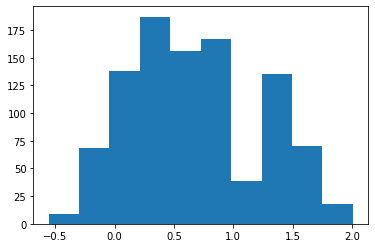

In [27]:
plt.hist(evals['Sharpe'])
plt.show()

In [28]:
best_portfolio = evals['w'][best_portfolio]
best_portfolio

KLBN11    0.403203
ENAT3     0.000457
RCSL3     0.596340
Name: Max Sharpe Ratio, dtype: float64

In [29]:
alloc = pd.DataFrame(best_portfolio).reset_index()
alloc.columns = ['Name','Allocation']
alloc

,Name,Allocation
0,KLBN11,0.403203
1,ENAT3,0.000457
2,RCSL3,0.596340


In [30]:
pf = build_portfolio(data=prices[best_portfolio.index],pf_allocation=alloc)

In [31]:
pf.properties()

----------------------------------------------------------------------
Stocks: KLBN11, ENAT3, RCSL3
Time window/frequency: 252
Risk free rate: 0.005
Portfolio Expected Return: 1.615
Portfolio Volatility: 0.802
Portfolio Sharpe Ratio: 2.008

Skewness:
     KLBN11     ENAT3     RCSL3
0 -0.536775  1.286813  2.821229

Kurtosis:
     KLBN11     ENAT3     RCSL3
0 -0.290568  0.881635  7.924799

Information:
   Allocation    Name
0    0.403203  KLBN11
1    0.000457   ENAT3
2    0.596340   RCSL3
----------------------------------------------------------------------
